MovieWriter ffmpeg unavailable; using Pillow instead.


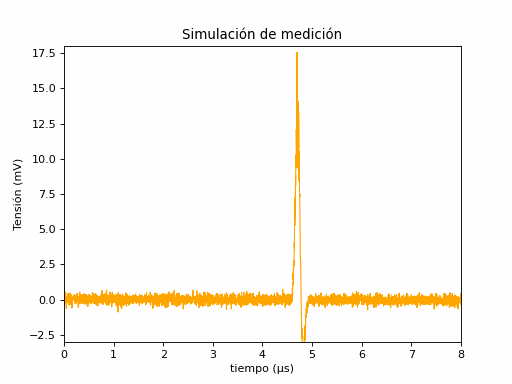

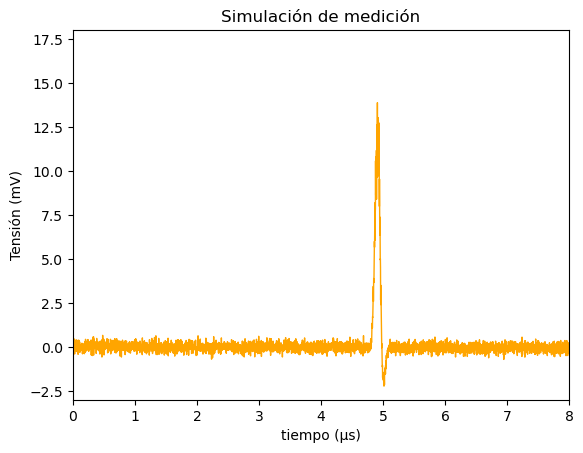

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import betaprime
from IPython.display import Image

# En primer lugar, se definen las funciones necesarias para la simulación.
def pulso(t, t0, sigma, omega, epsilon=1e-10):
    gauss = np.exp(-(t - t0)**2 / (2 * sigma**2))
    seno = np.cos(omega * (t - t0 + sigma))
    S = gauss * seno
    integral_S = np.trapz(S, t)
    if integral_S < epsilon:  # Evitar división por cero
        A = 0
    else:
        A = 1 / integral_S
    return A * S

# Simulamos la medición de un pulso en el tiempo t0, con sigma y omega aleatorios.
def simular_medicion(t, t0s, probs, sigma0=0.05, sigma_sigma=0.005, omega0=5*np.pi, sigma_omega=0.05):
    señal = np.zeros_like(t)
    for t0, p in zip(t0s, probs):
        if np.random.rand() < p:
            x = betaprime.rvs(a=4, b=2)
            t_centro = t0 + (x - 4 / 2) * 0.15
            sigma = np.random.normal(sigma0, sigma_sigma)
            omega = np.random.normal(omega0, sigma_omega)
            señal += pulso(t, t_centro, sigma, omega)
    ruido_rel = np.random.normal(1, 0.1, size=t.shape)
    ruido_abs = np.random.normal(0, 0.2, size=t.shape)
    fondo = (-t + 2) / 100
    return señal * ruido_rel + ruido_abs + fondo

# Se realiza la simulación de N mediciones, cada una con un conjunto de parámetros t0s y probs.
def simular_N_mediciones(N, t, t0s, probs):
    return np.array([simular_medicion(t, t0s, probs) for _ in range(N)])

# Tiempo para simulación
t = np.linspace(0, 8, 4000)
t0s = [1.8, 2.8, 5]
probs = [0.3, 0.1, 0.6]

# Simular animación: 100 mediciones
mediciones = simular_N_mediciones(100, t, t0s, probs)

# Crear animación
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
background = ax.fill_between(t, -3, 18, color='white', alpha=1)
ax.set_xlim(0, 8)
ax.set_ylim(-3, 18)
ax.set_xlabel('tiempo (μs)')
ax.set_ylabel('Tensión (mV)')
ax.set_title('Simulación de medición')
line = line, = ax.plot([], [], lw=1, color='orange')

def update(frame):
    line.set_data(t, mediciones[frame])
    return line,

ani = FuncAnimation(fig, update, frames=len(mediciones), blit=True)

# Guardar el .gif
ani.save('simulacion_medicion.gif', fps=5, dpi=80)

# Mostrar solo la animación .gif en el notebook
Image(filename='simulacion_medicion.gif')


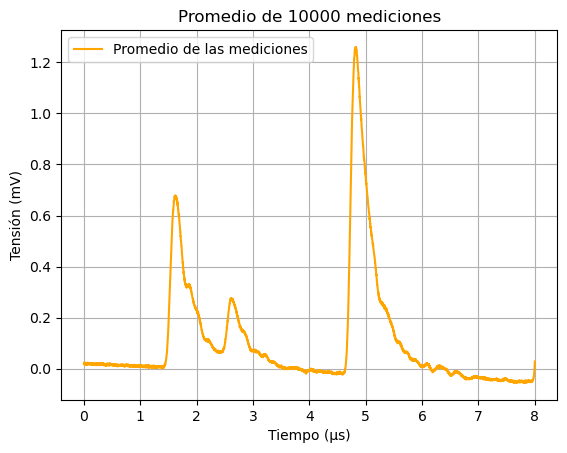

In [2]:
# Calcular el promedio de las mediciones
def promedio_mediciones(N, t, t0s, probs):
    mediciones = simular_N_mediciones(N, t, t0s, probs)
    promedio = np.mean(mediciones, axis=0)
    return promedio


# Simular N mediciones y calcular el promedio
N = 10000 # Se justa el valor de N para obtener más o menos mediciones
promedio = promedio_mediciones(N, t, t0s, probs)

# Crear gráfico del promedio
plt.plot(t, promedio, label="Promedio de las mediciones", color='orange')
plt.xlabel('Tiempo (μs)')
plt.ylabel('Tensión (mV)')
plt.title(f'Promedio de {N} mediciones')
plt.grid(True)
plt.legend()
plt.show()


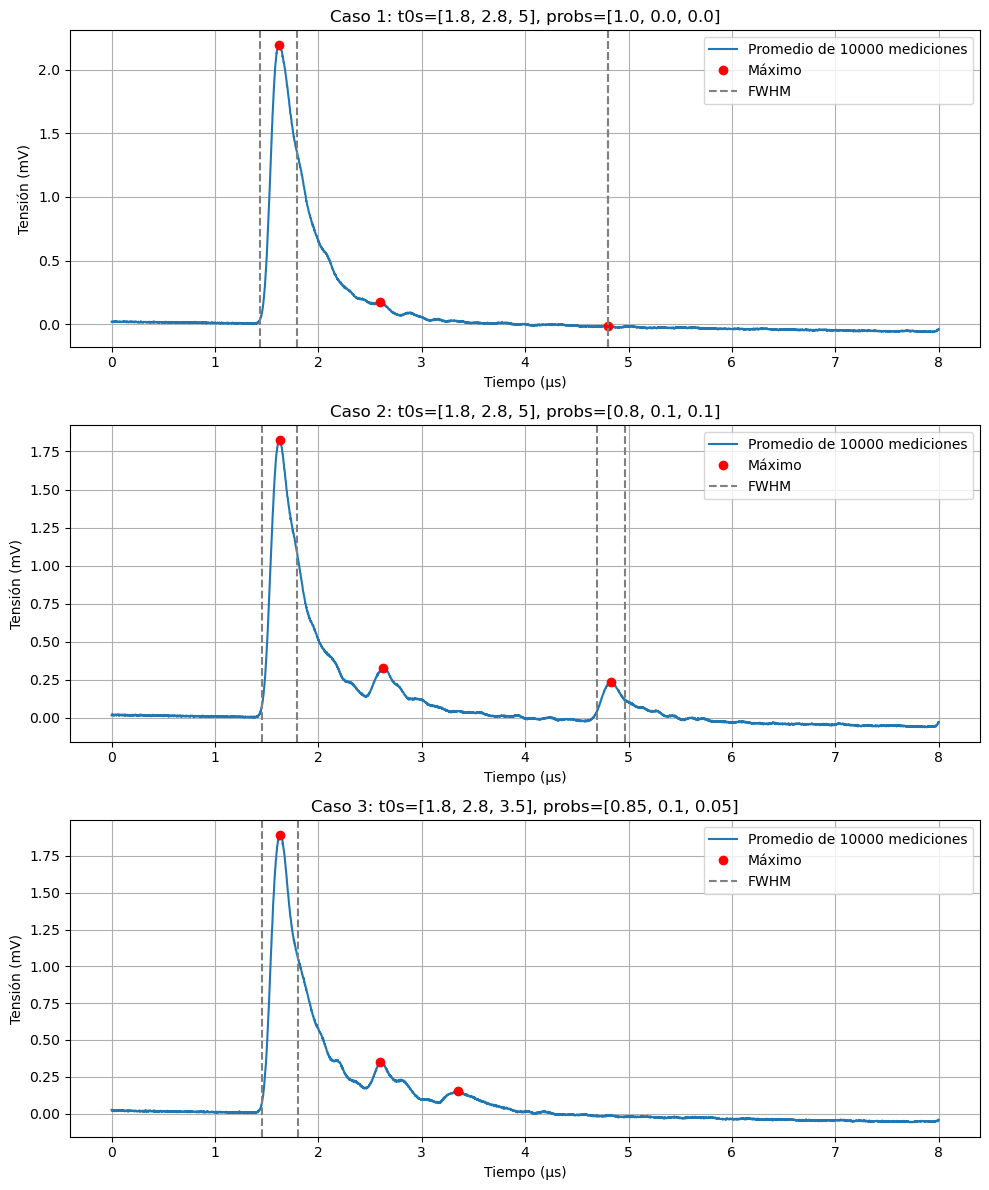


Áreas estimadas para cada pico en cada caso:

| Caso | Pico 1 | Pico 2 | Pico 3 |
|------|--------|--------|--------|
  Pico 1 en t0=1.6μs: Área = 1.000
  Pico 2 en t0=2.6μs: Área = 0.090
  Pico 3 en t0=4.8μs: Área = -0.025
| 1    | 1.000  | 0.090  | -0.025 |
  Pico 1 en t0=1.6μs: Área = 0.809
  Pico 2 en t0=2.6μs: Área = 0.162
  Pico 3 en t0=4.8μs: Área = 0.091
| 2    | 0.809  | 0.162  | 0.091  |
  Pico 1 en t0=1.6μs: Área = 0.848
  Pico 2 en t0=2.6μs: Área = 0.180
  Pico 3 en t0=3.4μs: Área = 0.086
| 3    | 0.848  | 0.180  | 0.086  |


In [ ]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Función para calcular máximo y FWHM
def max_y_fwhm(t, y):
    # Encontrar el máximo global
    idx_max = np.argmax(y)
    y_max = y[idx_max]
    t_max = t[idx_max]
    half_max = y_max / 2
    
    # Buscar cruce por la izquierda (antes del máximo)
    left_side = y[:idx_max]
    left_t = t[:idx_max]
    
    # Encontrar todos los puntos por debajo de la mitad del máximo
    below_half_left = np.where(left_side <= half_max)[0]
    
    if len(below_half_left) == 0:
        return t_max, y_max, np.nan
    
    # Tomar el último cruce significativo (ignorando oscilaciones pequeñas)
    # Buscamos el último punto donde la señal cruza la mitad y permanece debajo
    for i in range(len(below_half_left)-1, -1, -1):
        idx = below_half_left[i]
        # Verificar que los siguientes puntos también estén por debajo
        if np.all(left_side[idx:min(idx+10, len(left_side))] <= half_max):
            idx_left = idx
            break
    else:
        return t_max, y_max, np.nan
    
    # Interpolar para mayor precisión
    if idx_left + 1 < len(left_side):
        t_left = np.interp(half_max, 
                          [left_side[idx_left], left_side[idx_left+1]],
                          [left_t[idx_left], left_t[idx_left+1]])
    else:
        t_left = left_t[idx_left]
    
    # Buscar cruce por la derecha (después del máximo)
    right_side = y[idx_max:]
    right_t = t[idx_max:]
    
    below_half_right = np.where(right_side <= half_max)[0]
    
    if len(below_half_right) == 0:
        return t_max, y_max, np.nan
    
    # Tomar el primer cruce significativo
    for i in range(len(below_half_right)):
        idx = below_half_right[i]
        # Verificar que los puntos anteriores también estén por debajo
        if np.all(right_side[max(idx-10, 0):idx+1] <= half_max):
            idx_right = idx
            break
    else:
        return t_max, y_max, np.nan
    
    # Interpolar para mayor precisión
    if idx_right > 0:
        t_right = np.interp(half_max, 
                          [right_side[idx_right-1], right_side[idx_right]],
                          [right_t[idx_right-1], right_t[idx_right]])
    else:
        t_right = right_t[idx_right]
    
    fwhm = t_right - t_left
    return t_max, y_max, fwhm
# Modelo de pico interpolado basado en caso P = [1, 0, 0]
def construir_modelo(t, y):
    return interp1d(t, y, bounds_error=False, fill_value=0)

# Ajuste de un solo pico desplazado y escalado
def ajustar_pico(t, y_exp, modelo_interp, t0_guess):
    def modelo(t, t0, A):
        return A * modelo_interp(t - (t0 - t_modelo0))
    
    def error(params):
        t0, A = params
        return y_exp - modelo(t, t0, A)
    
    t_modelo0 = t[np.argmax(modelo_interp(t))]  # centro del modelo original
    res = least_squares(error, x0=[t0_guess, 1])
    t0_fit, A_fit = res.x
    return t0_fit, A_fit

# Configuración de tiempo
t = np.linspace(0, 8, 4000)

# Definición de los tres casos
casos = [
    ([1.8, 2.8, 5], [1.0, 0.0, 0.0]),
    ([1.8, 2.8, 5], [0.8, 0.1, 0.1]),
    ([1.8, 2.8, 3.5], [0.85, 0.1, 0.05]),
]

# Simulación y análisis de cada caso
resultados = []
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

for i, (t0s, probs) in enumerate(casos):
    # Simular mediciones y calcular promedio
    mediciones = simular_N_mediciones(10000, t, t0s, probs) #Se hace para 10000 mediciones
    # Calcular promedio de las mediciones
    prom = np.mean(mediciones, axis=0)
    
    # Graficar
    axs[i].plot(t, prom, label="Promedio de 10000 mediciones")
    axs[i].set_title(f"Caso {i+1}: t0s={t0s}, probs={probs}")
    axs[i].set_xlabel("Tiempo (μs)")
    axs[i].set_ylabel("Tensión (mV)")
    axs[i].grid(True)
    
    # Analizar cada pico
    datos_picos = []
    for t0 in t0s:
        # Seleccionar región alrededor del pico esperado
        idx_min = np.abs(t - (t0 - 0.3)).argmin()
        idx_max = np.abs(t - (t0 + 0.3)).argmin()
        t_local = t[idx_min:idx_max]
        y_local = prom[idx_min:idx_max]
        
        # Calcular máximo y FWHM
        t_max, y_max, fwhm = max_y_fwhm(t_local, y_local)
        
        # Marcar en gráfico
        axs[i].plot(t_max, y_max, 'ro', label='Máximo' if t0 == t0s[0] else "")
        axs[i].axvline(t_max - fwhm/2, ls='--', color='gray', label='FWHM' if t0 == t0s[0] else "")
        axs[i].axvline(t_max + fwhm/2, ls='--', color='gray')
        axs[i].legend()
        
        datos_picos.append((t_max, fwhm))
    
    resultados.append((prom, datos_picos))

plt.tight_layout()
plt.show()

# Ajuste y estimación de área usando el primer caso como plantilla
modelo_base = construir_modelo(t, resultados[0][0])
tabla = []

print("\nÁreas estimadas para cada pico en cada caso:\n")
print("| Caso | Pico 1 | Pico 2 | Pico 3 |")
print("|------|--------|--------|--------|")

for i, (prom, datos_picos) in enumerate(resultados):
    fila = []
    for j, (t0_est, _) in enumerate(datos_picos):
        t0_fit, A_fit = ajustar_pico(t, prom, modelo_base, t0_est)
        fila.append(A_fit)
        print(f"  Pico {j+1} en t0={t0_est:.1f}μs: Área = {A_fit:.3f}")
    
    # Formatear para tabla
    fila_str = [f"{x:.3f}" for x in fila]
    print(f"| {i+1:<4} | {fila_str[0]:<6} | {fila_str[1]:<6} | {fila_str[2]:<6} |")